In [23]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt

import os, sys
sys.path.append(os.path.abspath("../"))
from src.helper import show_clustered_image, calculate_cmyk_percentage

import numpy as np

In [ ]:
df = pd.read_csv("../outputs/csv/cmyk_of_a_pdf_file_by_dpi_kmeans_clustered.csv")
df = df[(df['dpi'] <= 100) & (df['library'] == 'pymupdf')]
df.reset_index(drop=True, inplace=True)
df

,library,dpi,converting_time,page,c,m,y,k,cmy,cmyk,price
0,pymupdf,9,0.017948,1,0.14,0.16,0.43,7.16,0.73,7.89,750
1,pymupdf,9,0.014375,2,0.52,0.45,0.00,3.83,0.97,4.80,500
2,pymupdf,9,0.008165,3,0.00,0.00,0.00,10.11,0.00,10.11,750
3,pymupdf,9,0.003376,4,0.00,0.00,0.00,13.64,0.00,13.64,750
4,pymupdf,9,0.003311,5,0.00,0.00,0.00,13.78,0.00,13.78,750
...,...,...,...,...,...,...,...,...,...,...,...
879,pymupdf,9,0.004169,880,0.00,0.00,0.00,5.22,0.00,5.22,500
880,pymupdf,9,0.008479,881,0.94,10.43,11.70,11.06,23.07,34.13,1500
881,pymupdf,9,0.001489,882,0.79,1.26,1.81,1.49,3.86,5.35,500
882,pymupdf,9,0.003796,883,2.35,27.01,30.17,12.14,59.53,71.67,2000


In [29]:
dpi_le_100 = df.dpi.unique().tolist()

cv_results_df = pd.DataFrame(
    {
        "mean_fit_time": [],
        "std_fit_time": [],
        "mean_score_time": [],
        "std_score_time": [],
        "param_algo__objective": [],
        "param_algo__max_depth": [],
        "param_algo__learning_rate": [],
        "param_algo__gamma": [],
        "params": [],
        "split0_test_score": [],
        "split1_test_score": [],
        "split2_test_score": [],
        "split3_test_score": [],
        "mean_test_score": [],
        "std_test_score": [],
        "rank_test_score": [],
        "features": [],
        "dpi": [],
        "training_score": [],
        "best_score_cv": [],
        "testing_score": [],
    }
)

for dpi in dpi_le_100:
    for feature in [["cmy", "k"], ["c", "m", "y", "cmyk"], ["c", "m", "y", "k", "cmyk"], ["cmy", "k", "cmyk"]]:
        print(f"Training with {dpi} DPI and Features: {feature}")
        X = df[df.dpi == dpi][feature]
        y = df[df.dpi == dpi].price

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

        rfc_params = {
            'algo__n_estimators': [200, 300],
            'algo__max_features': np.linspace(0.4, 0.8, 15),
            'algo__max_depth': [5, 10, 25, 45, 50, 55, 60],
            'algo__min_samples_leaf': [5, 6, 7, 8]
        }

        classification_pipe = Pipeline([
            ("algo", RandomForestClassifier())
        ])

        model = RandomizedSearchCV(
            classification_pipe,
            param_distributions=rfc_params,
            cv=5,
            scoring="f1_weighted",
            verbose=1,
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test)

        temp = pd.DataFrame(model.cv_results_)
        temp["features"] = str(feature)
        temp["dpi"] = dpi
        temp["training_score"] = model.score(X_train, y_train)
        temp["best_score_cv"] = model.best_score_
        temp["testing_score"] = model.score(X_test, y_test)

        cv_results_df = pd.concat([cv_results_df, temp], ignore_index=True)

Training with 1 DPI and Features: ['cmy', 'k']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 1 DPI and Features: ['c', 'm', 'y', 'cmyk']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 1 DPI and Features: ['c', 'm', 'y', 'k', 'cmyk']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 1 DPI and Features: ['cmy', 'k', 'cmyk']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 2 DPI and Features: ['cmy', 'k']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 2 DPI and Features: ['c', 'm', 'y', 'cmyk']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 2 DPI and Features: ['c', 'm', 'y', 'k', 'cmyk']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 2 DPI and Features: ['cmy', 'k', 'cmyk']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 3 DPI and Features: ['cmy', 'k']
Fitting 5 folds for

KeyboardInterrupt: 

In [31]:
df_converting_time = pd.read_csv(
    "../outputs/csv/pdf_to_img_converting_time_by_libraries.csv"
)
df_converting_time = df_converting_time[
    (df_converting_time.dpi <= 100) & (df_converting_time.library == "pymupdf")
]
dpi_map = {x[1]["dpi"]: x[1]["converting_time"] for x in df_converting_time.iterrows()}
cv_results_df["converting_time"] = cv_results_df.dpi.replace(dpi_map)

cv_results_df.to_csv("../outputs/csv/cv_results_rfc_1-100dpi_and_feature_tuning.csv", index=False)

cv_result_cleaned = cv_results_df.drop_duplicates(['best_score_cv', 'testing_score', 'dpi', 'converting_time', 'features'])
cv_result_cleaned.sort_values(
    by=["testing_score", "best_score_cv", "dpi", "converting_time"], ascending=[False, True, False, True]
).iloc[:50,:][["testing_score", "dpi", "best_score_cv", "converting_time", "features"]]

,testing_score,dpi,best_score_cv,converting_time,features
600,0.990853,150.0,0.987116,150.000000,"['cmy', 'k']"
620,0.989724,150.0,0.984211,150.000000,"['c', 'm', 'y', 'k', 'cmyk']"
580,0.986241,100.0,0.981986,98.536494,"['c', 'm', 'y', 'k', 'cmyk']"
560,0.983958,100.0,0.987631,98.536494,"['cmy', 'k']"
400,0.981796,20.0,0.974183,10.254706,"['cmy', 'k']"
520,0.981759,50.0,0.976836,24.475727,"['cmy', 'k']"
610,0.980487,150.0,0.962934,150.000000,"['c', 'm', 'y', 'cmyk']"
540,0.978334,50.0,0.979700,24.475727,"['c', 'm', 'y', 'k', 'cmyk']"
460,0.978216,30.0,0.978628,12.581692,"['c', 'm', 'y', 'k', 'cmyk']"
480,0.977281,40.0,0.983675,17.452735,"['cmy', 'k']"


In [25]:
X = df5[['cmy', 'k']]
y = df5.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [27]:
col_transformer = ColumnTransformer([
    # ("scale", RobustScaler(), ['c', 'm', 'y', 'k', 'sum'])
])

rfc_params = {
    'algo__n_estimators': [200, 300],
    'algo__max_features': np.linspace(0.4, 0.8, 15),
    'algo__max_depth': [5, 10, 25, 45, 50, 55, 60],
    'algo__min_samples_leaf': [5, 6, 7, 8]
}

classification_pipe = Pipeline([
    # ("prep", col_transformer),
    ("algo", RandomForestClassifier())
])

model = RandomizedSearchCV(classification_pipe, param_distributions=rfc_params, cv=5, verbose=1, scoring='f1_weighted')
model.fit(X_train, y_train)

print(model.best_params_)
model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'algo__n_estimators': 300, 'algo__min_samples_leaf': 7, 'algo__max_features': 0.4571428571428572, 'algo__max_depth': 55}


(0.9949149666318093, 0.9813505856558716, 0.9897024638833045)

In [28]:
y_pred = model.predict(X_test)

cfr = classification_report(y_test, y_pred)
print(cfr)

              precision    recall  f1-score   support

         500       1.00      1.00      1.00        59
         750       1.00      1.00      1.00        18
        1000       0.98      0.97      0.98        63
        1500       0.99      0.99      0.99       146
        2000       1.00      1.00      1.00         6

    accuracy                           0.99       292
   macro avg       0.99      0.99      0.99       292
weighted avg       0.99      0.99      0.99       292



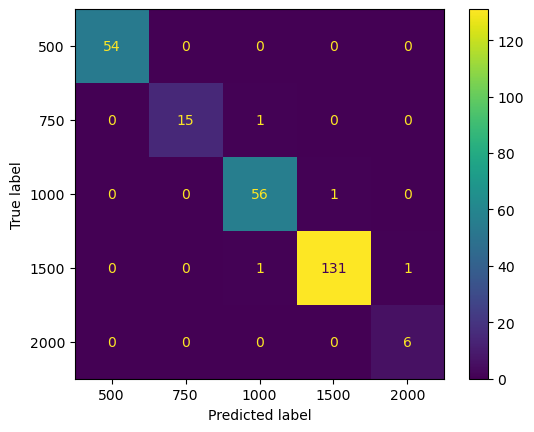

In [20]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[500,750,1000,1500,2000])
disp.plot()

In [10]:
import pickle

pickle.dump(model, open("../models/random_forest_classifier_c_m_y_k_sum_5_dpi_v2.pkl", 'wb'))
pickle.dump(model.best_estimator_, open("../models/random_forest_classifier_c_m_y_k_sum_5_dpi_small_v2.pkl", 'wb'))

## Support Vector Classifier (SVC)

In [11]:
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer

In [ ]:
col_transformer = ColumnTransformer([
    ("scale", PowerTransformer(), ['c', 'm', 'y', 'k', 'sum']),
])

svc_params = {
		'algo__C': np.linspace(0.001, 1, 20),
    'algo__kernel': ['linear', 'poly','rbf', 'sigmoid'],
    'algo__gamma': np.linspace(0.1, 1, 100),
    'algo__degree': [3, 4, 5],
    'algo__class_weight': ['balanced', {500:3, 750:3, 1000:2, 1500:1, 2000:1}],
}

classification_pipe = Pipeline([
    ("prep", col_transformer),
    ("algo", SVC())
])

model = RandomizedSearchCV(classification_pipe, param_distributions=svc_params, cv=4, verbose=1) 
model.fit(X_train, y_train)

print(model.best_params_)
model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
{'algo__kernel': 'rbf', 'algo__gamma': 0.5181818181818182, 'algo__degree': 4, 'algo__class_weight': 'balanced', 'algo__C': 0.3164736842105263}


(0.9433656957928802, 0.9255760368663595, 0.9548872180451128)

In [39]:
y_pred = model.predict(X_test)

cfr = classification_report(y_test, y_pred)
print(cfr)

              precision    recall  f1-score   support

         500       0.98      1.00      0.99        54
         750       1.00      0.88      0.93        16
        1000       0.93      0.97      0.95        77
        1500       0.98      0.96      0.97       113
        2000       1.00      1.00      1.00         6

    accuracy                           0.97       266
   macro avg       0.98      0.96      0.97       266
weighted avg       0.97      0.97      0.97       266



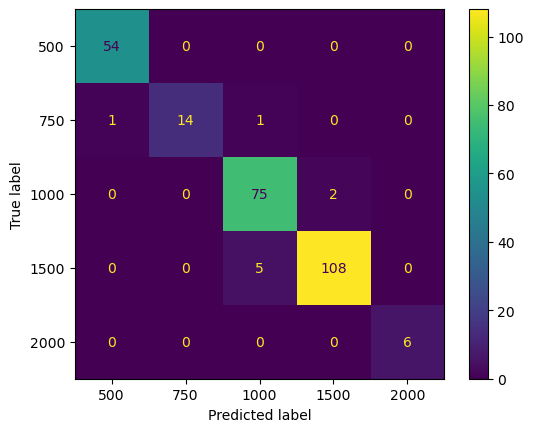

In [40]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[500,750,1000,1500,2000])
disp.plot()

## XGBoost

In [97]:
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.preprocessing import PowerTransformer

In [130]:
df = pd.read_csv("../outputs/csv/cmyk_of_a_pdf_file_by_dpi.csv")
df5 = df[(df['dpi'] == 10) & (df['library'] == 'pymupdf')]
df5.reset_index(drop=True, inplace=True)

df5.drop_duplicates(['library', 'dpi', 'page'], inplace=True)

df_clustered = pd.read_csv("../datasets/clustered_cmy_k_agglomerative_300dpi.csv")
df5['label'] = df_clustered.label.copy()



df5.label.replace({500:0, 750:1, 1000:2, 1500:3, 2000:4}, inplace=True)
df5

/var/folders/py/8_pc5kdx5jx5nfc61_n_79dc0000gp/T/ipykernel_74648/763714842.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5.drop_duplicates(['library', 'dpi', 'page'], inplace=True)
/var/folders/py/8_pc5kdx5jx5nfc61_n_79dc0000gp/T/ipykernel_74648/763714842.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['label'] = df_clustered.label.copy()
/var/folders/py/8_pc5kdx5jx5nfc61_n_79dc0000gp/T/ipykernel_74648/763714842.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.


,library,dpi,converting_time,page,c,m,y,k,sum,label
0,pymupdf,10,0.016167,1,0.17,0.18,0.48,6.97,7.80,1
1,pymupdf,10,0.013793,2,0.52,0.45,0.00,3.79,4.76,0
2,pymupdf,10,0.006554,3,0.00,0.00,0.00,11.75,11.75,1
3,pymupdf,10,0.004329,4,0.00,0.00,0.00,12.85,12.85,1
4,pymupdf,10,0.003569,5,0.00,0.00,0.00,12.98,12.98,1
...,...,...,...,...,...,...,...,...,...,...
879,pymupdf,10,0.006095,880,0.00,0.00,0.00,5.09,5.09,0
880,pymupdf,10,0.006145,881,0.97,10.38,11.68,10.86,33.89,3
881,pymupdf,10,0.001488,882,0.80,1.28,1.83,1.51,5.42,0
882,pymupdf,10,0.005738,883,2.29,26.82,30.32,11.82,71.25,4


In [131]:
X = df5[['c', 'm', 'y', 'k', 'sum']]
y = df5.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [132]:
col_transformer = ColumnTransformer([
    # ("scale", PowerTransformer(), ['c', 'm', 'y', 'k', 'sum'])
])

xgb_params = {
	'algo__objective': ['multi:softprob', 'multi:softmax'],
	'algo__gamma': np.linspace(0, 0.8, 50),
	'algo__learning_rate': [0.001, 0.01, 0.05, 0.1],
	'algo__max_depth':[5, 10, 25, 45, 50, 55, 60],
	# 'algo__reg_lambda': None,
}

classification_pipe = Pipeline([
    # ("prep", col_transformer),
    ("algo", XGBClassifier())
])


model = RandomizedSearchCV(classification_pipe, param_distributions=xgb_params, verbose=1)
model.fit(X_train, y_train)
print(model.best_params_)

y_pred = model.predict(X_test)
model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'algo__objective': 'multi:softprob', 'algo__max_depth': 45, 'algo__learning_rate': 0.1, 'algo__gamma': 0.4408163265306123}


(1.0, 0.9763851303233159, 0.9828767123287672)

In [133]:
cm = classification_report(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        18
           2       0.94      1.00      0.97        85
           3       1.00      0.96      0.98       124
           4       1.00      1.00      1.00         6

    accuracy                           0.98       292
   macro avg       0.99      0.99      0.99       292
weighted avg       0.98      0.98      0.98       292



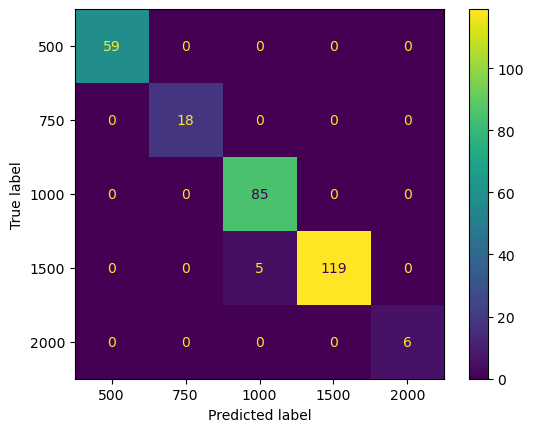

In [134]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[500,750,1000,1500,2000])
disp.plot()

In [135]:
import pickle

pickle.dump(model, open("../models/xgboost_99_c_m_y_k_sum_10_dpi.pkl", 'wb'))
pickle.dump(model.best_estimator_, open("../models/xgboost_99_c_m_y_k_sum_10_dpi_small.pkl", 'wb'))